In [2]:
import json
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date, datetime, timedelta

from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

---

**Brief: Look at data collection and handling process, and suggest some ideas of how this data can be used to enhance the client's product and make it more popular among professional sailors and boat manufacturers.**

# Contents:

1. **Reading in data**
2. **Exploration and cleaning**
    - 2a. Looking at DateTime
    - 2b. Looking at missing data 
3. **Feature engineering**
    - 3a. Looking at correlations 
    - 3b. Iterative feature removal by VIF
4. **Saving datasets**

---

## 1. Reading in data

In [39]:
with open('data/data_dict.json') as output_file:
    dic = json.load(output_file)

**Data dictionary needs to be complete - with descriptions, ranges, units - all filled in accordingly.**

In [40]:
'{} instances where information is missing and needs to be filled...'.format(
len([j for i in dic.values() for j in i.values() if j == None or j == ' ']))

'24 instances where information is missing and needs to be filled...'

In [5]:
df = pd.read_csv('data/test_data.csv')

In [6]:
df.shape

(220000, 27)

---

## 2. Exploration and cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220000 entries, 0 to 219999
Data columns (total 27 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CurrentSpeed  219833 non-null  float64
 1   CurrentDir    219832 non-null  float64
 2   TWS           219837 non-null  float64
 3   TWA           219833 non-null  float64
 4   AWS           219834 non-null  float64
 5   AWA           219838 non-null  float64
 6   Roll          219833 non-null  float64
 7   Pitch         219836 non-null  float64
 8   HeadingMag    219835 non-null  float64
 9   HoG           219838 non-null  float64
 10  HeadingTrue   219837 non-null  float64
 11  AirTemp       219840 non-null  float64
 12  Longitude     219836 non-null  float64
 13  Latitude      219840 non-null  float64
 14  SoG           219842 non-null  float64
 15  SoS           219840 non-null  float64
 16  AvgSoS        219838 non-null  float64
 17  VMG           219837 non-null  float64
 18  Rudd

### 2a. Looking at Datetime 

First lets look at the DateTime and check if the data is recorded chronoligically in even time intervals.

In [43]:
df.DateTime = pd.to_datetime(df.loc[:,'DateTime'])

In [44]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

In [45]:
our_timestamps = df.DateTime.to_list()

set(list(perdelta(datetime(2019, 4, 14, 0, 0, 0),
                      datetime(2019, 4, 16, 7, 33, 19), 
                      timedelta(seconds=1)))) - set(our_timestamps)

{datetime.datetime(2019, 4, 14, 11, 5, 59),
 datetime.datetime(2019, 4, 14, 22, 42, 18),
 datetime.datetime(2019, 4, 14, 22, 59, 11),
 datetime.datetime(2019, 4, 15, 1, 24, 28),
 datetime.datetime(2019, 4, 15, 9, 45, 48)}

In [46]:
'{} instances were datetime has not been recorded but can be inferred by the previous second'.format(
    df[df.DateTime.isnull()].shape[0])

'5 instances were datetime has not been recorded but can be inferred by the previous second'

No obvious patterns to why this this data is missing, but 5 points are insignificant relative to the rest of the data.

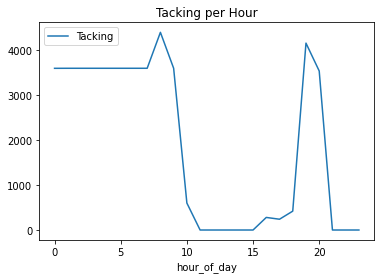

In [53]:
df['hour_of_day'] = df.DateTime.dt.hour

df.groupby('hour_of_day')[['Tacking']].sum().plot(kind='line')
plt.title('Tacking per Hour');

Looks like there is tacking in early hours of the morning and at 7pm

In [47]:
df.DateTime.describe() 

/Users/ella.franks/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  219995
unique                 199995
top       2019-04-16 05:34:00
freq                        2
first     2019-04-14 00:00:00
last      2019-04-16 07:33:19
Name: DateTime, dtype: object

**Hard to conclude much about the time with so little data (2 days) and since we have the weather data, it is not a critical feature for modelling, however, I would recommend collecting more data for the forcasting task**

### 2b. Looking at missing data

Let's look if there are any patterns in the missing data and if we can impute the values

In [55]:
df.dropna(thresh=26).shape #data stays same between threshold 3 and 26

(219843, 28)

In [57]:
df[df.isnull().sum(axis=1) >= 25].DateTime.min(), df[df.isnull().sum(axis=1) >= 25].DateTime.max()

(Timestamp('2019-04-14 16:56:04'), Timestamp('2019-04-14 16:58:40'))

**Between the 16:56 to 16:58 the sensors stopped picking up any data other than the time and the manual tacks added by the superviser. Would recommend looking into why this is happening? This may be because the sensors were switched off or stopped working**

Going to drop these for now and look at remaining nulls

In [7]:
df.dropna(thresh=25, inplace=True)

In [64]:
df[df.isna().any(axis=1)].shape[0]/df.shape[0] #only 163 rows which still have nulls 

0.0007414382081758346

Not a lot when considering the size of the data

**If in the future, we do not want to drop the remaining data, there are a number of ways to impute missing values:**

**If you have all two out of three variables of boat speed (current speed), apparant wind speed, and true wind speed, you can roughly calculate the remaining third variable:**

TWS = apparant wind speed - (.80* boatspeed) 

In [8]:
def determine_TWS(df):
    return df.AWS - (.80*df.CurrentSpeed)

In [9]:
tws_inferences = df[df.TWS.isnull()].apply(determine_TWS, axis=1)

In [10]:
df.TWS.fillna(tws_inferences, inplace=True)

**Could do this for all the missing values, but for now will drop the remaining nulls**

In [11]:
df.dropna(inplace=True)

In [12]:
df.shape

(219686, 27)

---

## 3. Feature engineering

### 3a. Looking at correlations

Concious that that the client, professional sailors and boat manufacturers may find **all** these features valuable so they are important to record, however if needing to reduce the amount of data collected then recommendation would be not collecting the highly correlated variables.


Lets look at the correlation all of the variables

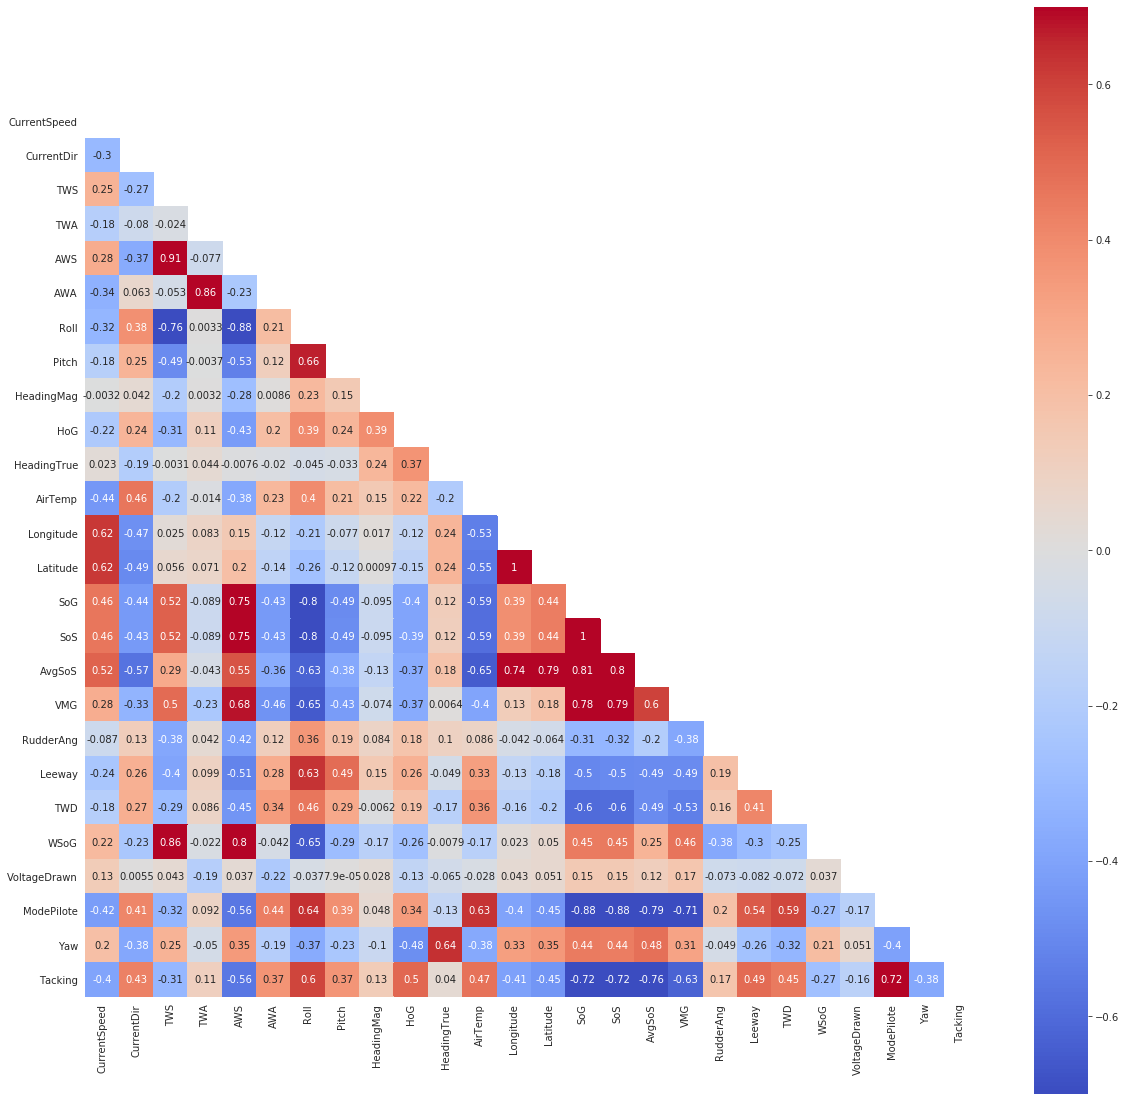

In [97]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 20))
    ax = sns.heatmap(corr, annot=True, mask=mask, vmax=.7, vmin=-.7, square=True, cmap='coolwarm')

In order to run a classification model, the observations must be independant with ittle or no multicollinearity. This means that the independent variables should not be too highly correlated with each other. This is so one is able to distinguish between the individual effects of the independent variables on the dependent variable. In the plot above, you can already see that there are a few features that are highly correlated with eachother and subsequently can be removed for the modelling. 

One among SoG and SoS could be unnecessary and we may decide to drop one and keep the most useful.

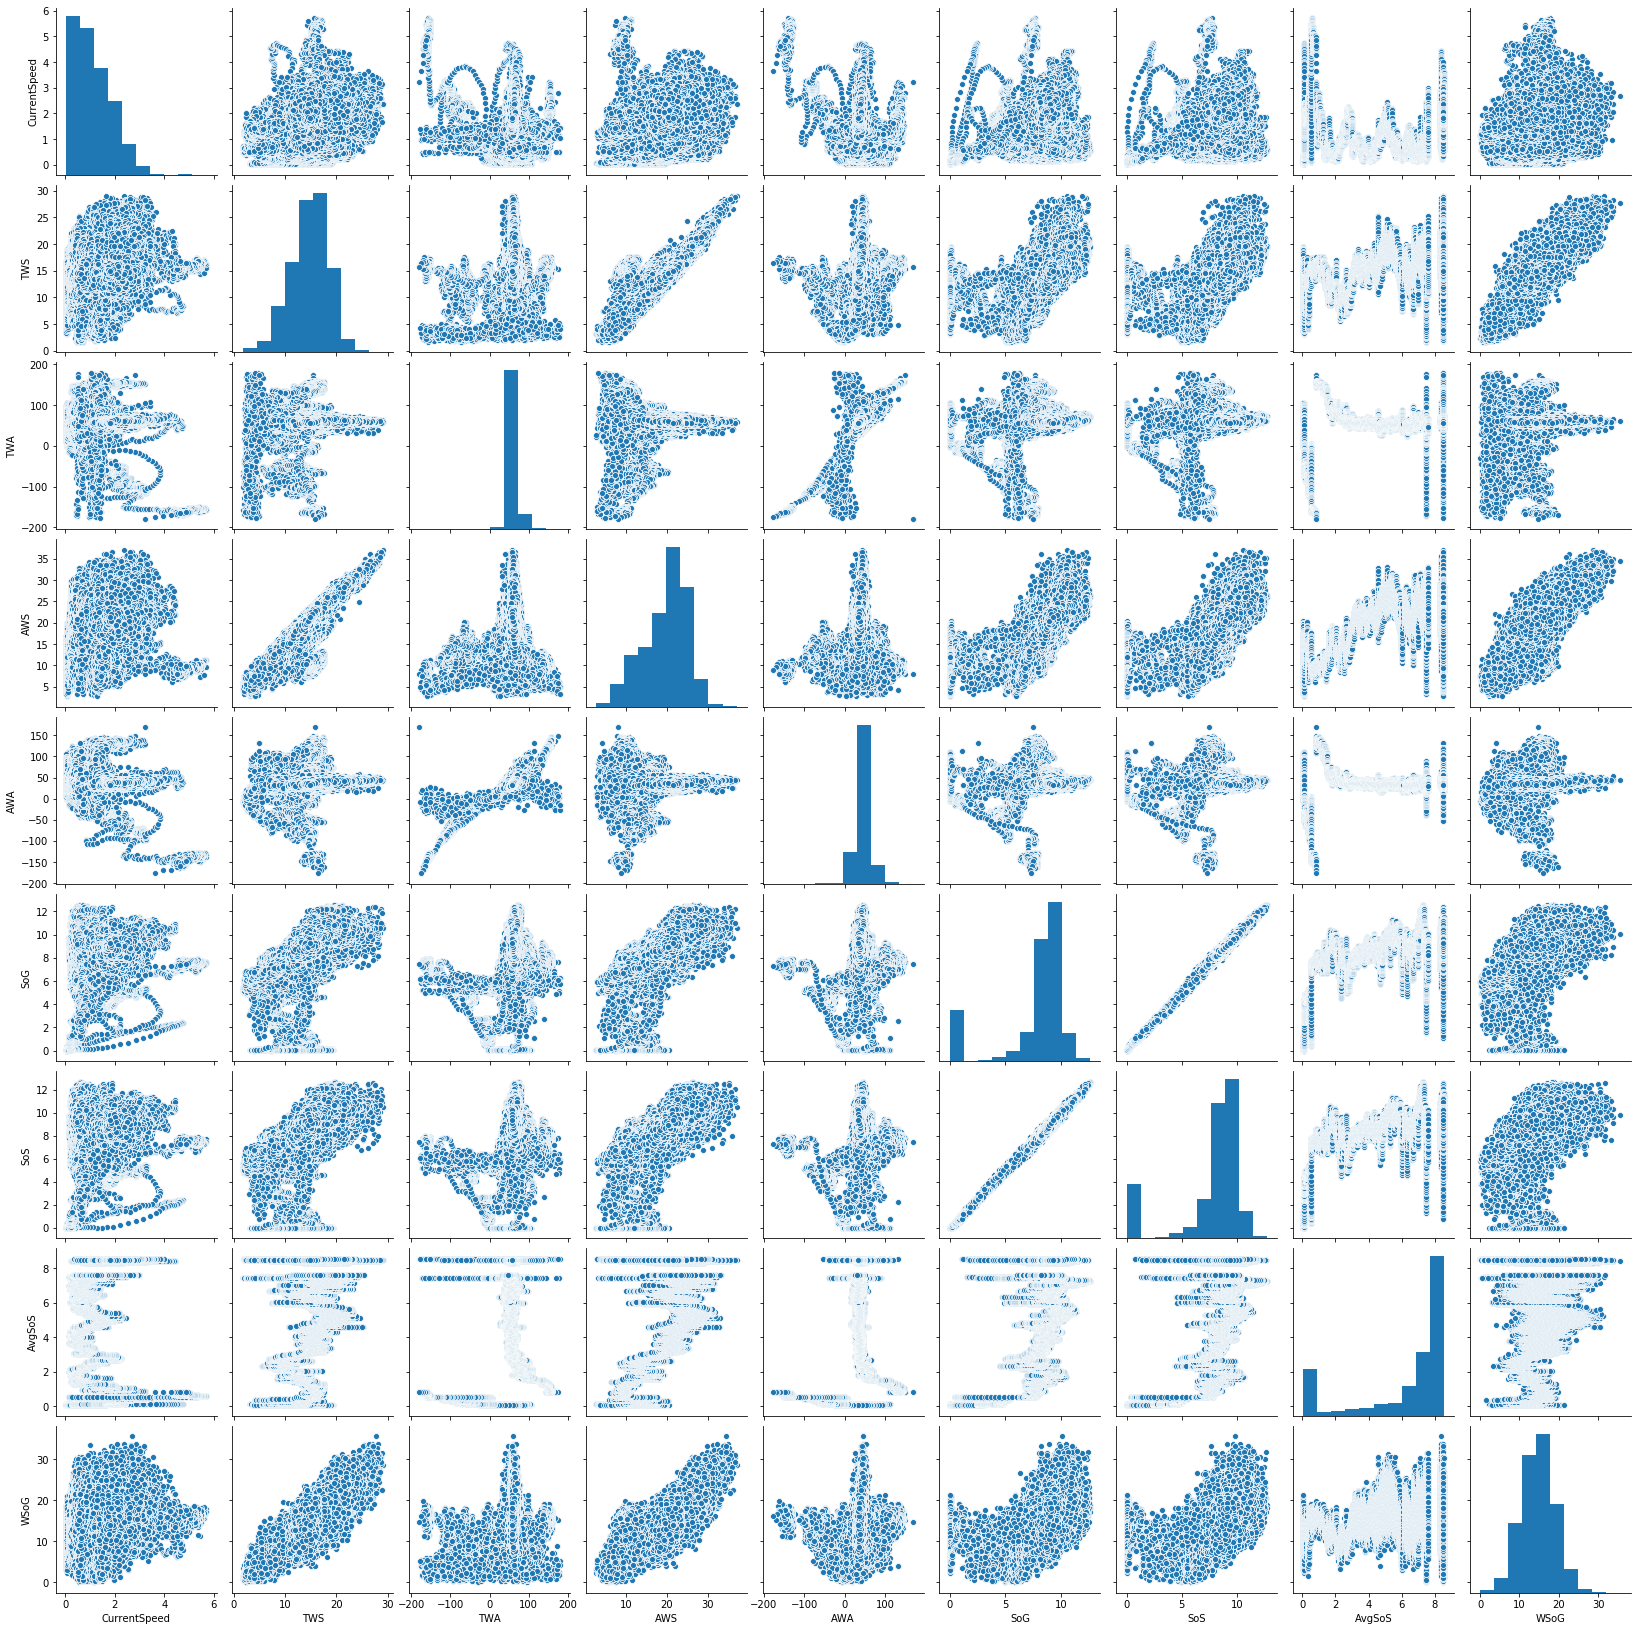

In [327]:
sns.pairplot(df[['CurrentSpeed', 'TWS', 'TWA', 'AWS', 'AWA', 'SoG', 'SoS', 'AvgSoS', 'WSoG']])

Looking at these pairplots above - some of relationships looks polynomial (like SoG/SoS and WSoG) and others are very correlated against one another (SoG and SoS).

There are many ways to perform feature selection, including regularizaion, looking at feature importances or doing a PCA. In this case, I will look at the variance inflation factors to help decide which features to keep.

### 3b. Iterative feature removal by VIF

VIF is the extent to which the variance is "inflated" by the existence of correlation among the predictor variables in the model. The general rule of thumb is that VIFs exceeding 4 warrant further investigation, while VIFs exceeding 10 are signs of serious multicollinearity requiring correction.

When initially calculating VIF, I chose to remove HeadingTrue as this was an infinate value, as well as HoG and Yaw. I also removed datetime as it was not a useful variable to include.

In [70]:
cols = ['CurrentSpeed',
 'CurrentDir',
 'TWS',
 'TWA',
 'AWS',
 'AWA',
 'Roll',
 'Pitch',
 'HeadingMag',
 'HoG',
 'AirTemp',
 'Longitude',
 'Latitude',
 'SoG',
 'SoS',
 'AvgSoS',
 'VMG',
 'RudderAng',
 'Leeway',
 'TWD',
 'WSoG',
 'VoltageDrawn',
 'ModePilote',
 'Yaw']

Let's standardise in order to ensure we can compare the units.

In [80]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df[cols]),columns = df[cols].columns, index=df[cols].index)

In [26]:
def vif_analyse(data, cols):
    
    vif_data = pd.DataFrame({'feature':cols})
  
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(data[cols].values, i)
                          for i in range(len(cols))]
  
    print(vif_data)
    
    return vif_data

In [27]:
vif_data = vif_analyse(scaled_df, cols)

         feature          VIF
0   CurrentSpeed     2.875585
1     CurrentDir     1.750381
2            TWS    20.103441
3            TWA     8.101081
4            AWS    32.472186
5            AWA    10.937015
6           Roll    10.515170
7          Pitch     2.291201
8     HeadingMag     1.479993
9            HoG     1.880437
10       AirTemp     2.315188
11     Longitude   900.803580
12      Latitude  1073.677323
13           SoG   730.727079
14           SoS   758.032726
15        AvgSoS    34.189380
16           VMG     4.131594
17     RudderAng     1.368958
18        Leeway     2.501781
19           TWD     1.792416
20          WSoG     4.562432
21  VoltageDrawn     1.186577
22    ModePilote     6.855284
23           Yaw     1.783589


In [28]:
list(vif_data[vif_data['VIF']>100].feature)

['Longitude', 'Latitude', 'SoG', 'SoS']

We won't use long or lat but we may want SoG. Let's remove both long + lat and lets remove SoS because its higher than SoG and we have AvgSoS

In [29]:
_ = vif_analyse(scaled_df, [col for col in cols if col not in ['SoS', 'Longitude', 'Latitude']])

         feature        VIF
0   CurrentSpeed   2.159879
1     CurrentDir   1.692551
2            TWS  19.366462
3            TWA   8.013457
4            AWS  30.946974
5            AWA  10.829936
6           Roll   9.782799
7          Pitch   2.265490
8     HeadingMag   1.461380
9            HoG   1.823807
10       AirTemp   2.195733
11           SoG  15.585222
12        AvgSoS   5.658056
13           VMG   3.548511
14     RudderAng   1.315733
15        Leeway   2.213919
16           TWD   1.787169
17          WSoG   4.543889
18  VoltageDrawn   1.182421
19    ModePilote   6.790739
20           Yaw   1.756438


In [30]:
_ = vif_analyse(scaled_df, [col for col in cols if col not in ['SoS', 'Longitude', 'Latitude', 'AWS', 'SoG']])

         feature       VIF
0   CurrentSpeed  1.701961
1     CurrentDir  1.685145
2            TWS  6.356287
3            TWA  7.129577
4            AWA  9.413703
5           Roll  6.747087
6          Pitch  2.115519
7     HeadingMag  1.353053
8            HoG  1.750830
9        AirTemp  2.167928
10        AvgSoS  4.646000
11           VMG  3.133118
12     RudderAng  1.310457
13        Leeway  1.851518
14           TWD  1.763550
15          WSoG  4.474374
16  VoltageDrawn  1.114871
17    ModePilote  4.969362
18           Yaw  1.663935


In [31]:
_ = vif_analyse(scaled_df, [col for col in cols if col not in ['SoS', 'Longitude', 'Latitude', 'AWS', 'SoG', 'AWA']])

         feature       VIF
0   CurrentSpeed  1.647268
1     CurrentDir  1.656195
2            TWS  6.179331
3            TWA  1.224146
4           Roll  6.732642
5          Pitch  2.114949
6     HeadingMag  1.352638
7            HoG  1.750042
8        AirTemp  2.167825
9         AvgSoS  4.572024
10           VMG  3.076267
11     RudderAng  1.299355
12        Leeway  1.850628
13           TWD  1.679386
14          WSoG  4.461258
15  VoltageDrawn  1.114815
16    ModePilote  4.582754
17           Yaw  1.663655


In [32]:
_ = vif_analyse(scaled_df, [col for col in cols if col not in ['SoS', 'Longitude', 'Latitude', 'ModePilote',
                                                               'AWS', 'SoG', 'AWA', 'Roll', 'TWS']])

         feature       VIF
0   CurrentSpeed  1.603970
1     CurrentDir  1.612366
2            TWA  1.204191
3          Pitch  1.469105
4     HeadingMag  1.315626
5            HoG  1.737728
6        AirTemp  1.956152
7         AvgSoS  3.388337
8            VMG  2.624034
9      RudderAng  1.278699
10        Leeway  1.655031
11           TWD  1.595804
12          WSoG  1.513351
13  VoltageDrawn  1.087163
14           Yaw  1.656269


In [33]:
final = vif_analyse(scaled_df, [col for col in cols if col not in ['SoS', 'Longitude', 'Latitude', 'ModePilote',
                                                               'AWS', 'SoG', 'AWA', 'Roll', 'TWS']])

         feature       VIF
0   CurrentSpeed  1.603970
1     CurrentDir  1.612366
2            TWA  1.204191
3          Pitch  1.469105
4     HeadingMag  1.315626
5            HoG  1.737728
6        AirTemp  1.956152
7         AvgSoS  3.388337
8            VMG  2.624034
9      RudderAng  1.278699
10        Leeway  1.655031
11           TWD  1.595804
12          WSoG  1.513351
13  VoltageDrawn  1.087163
14           Yaw  1.656269


**List of features to keep for the model:**

In [34]:
len(list(final[final['VIF']<=4].feature))

15

In [35]:
cols_to_keep = list(final[final['VIF']<=10].feature)
cols_to_keep.append('Tacking')

**We keep:**
- CurrentSpeed: The speed of the current 
- CurrentDir: The direction in which the current is going
- TWA: True wind angle 
- Pitch: Pitch angle
- HeadingMag: Magnetic heading is your direction relative to magnetic north, read from your magnetic compass
- HoG: Heading is the direction that the nose is pointed
- AirTemp: Air temperature 
- AvgSoS: Average speed over surface
- VMG: Velocity made good. Calculated as Speed over surface * cos(True Wind angle)
- RudderAng: Angle of the steer
- Leeway: Amount by which the wind acting on your boat pushes you off course
- TWD: True wind direction 
- WSoG: Wind speed over ground
- VoltageDrawn: Voltage drawn by the system of one of its parts
- Yaw: Angle of oscillation/twist (can measure deviation erratically from a course)

*These will hopefully be enough to make a good model prediction with high F1 scores for both classes.*

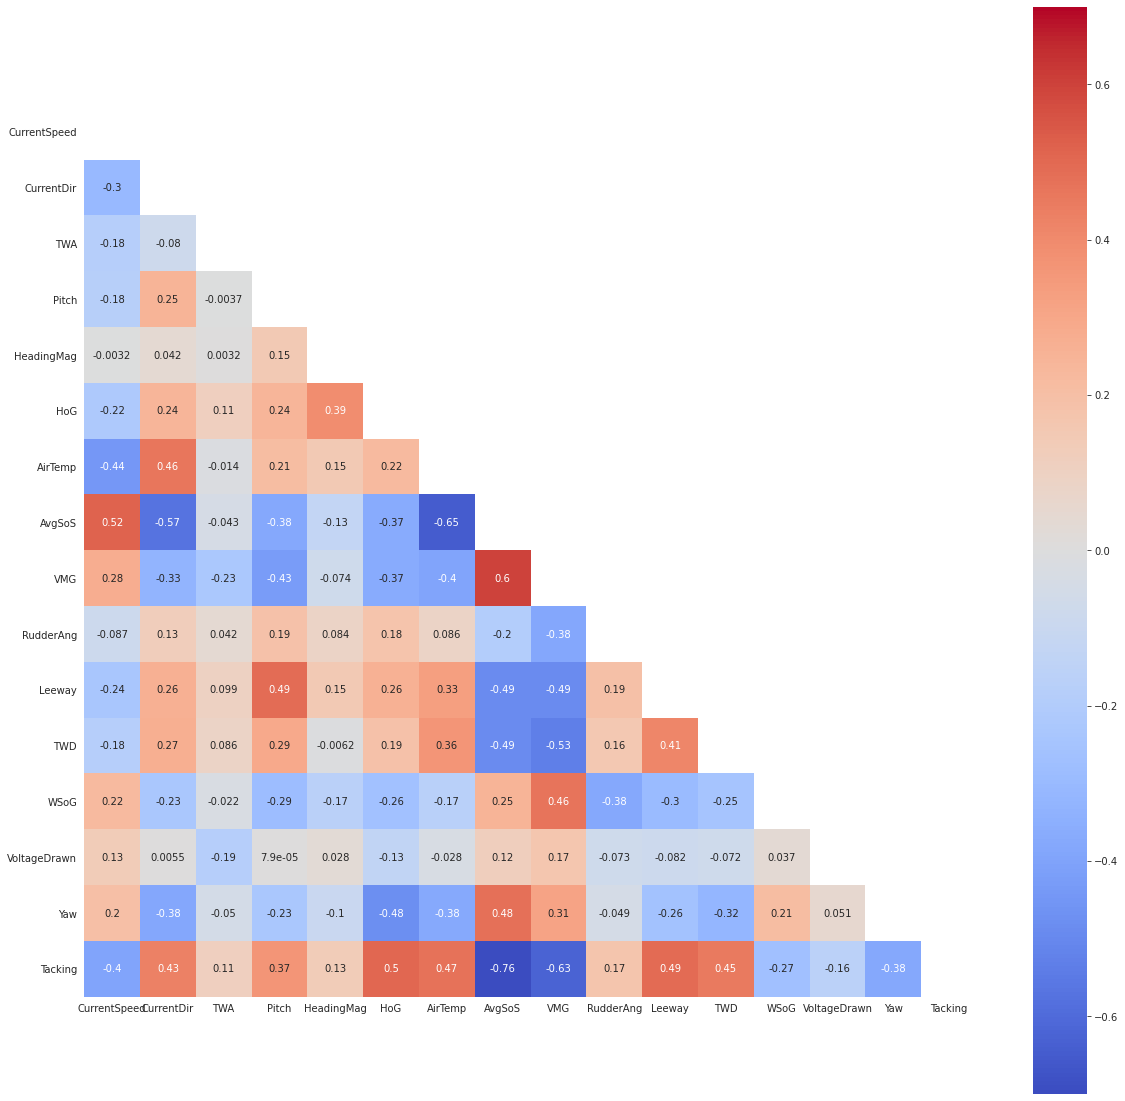

In [84]:
corr = df[cols_to_keep].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 20))
    ax = sns.heatmap(corr, annot=True, mask=mask, vmax=.7, vmin=-.7, square=True, cmap='coolwarm')

Looks like we no longer have variables that are problematically correlated with one another.

---

## 4. Saving datasets

Saving full dataset

In [85]:
df.to_csv('all_data.csv')

Saving feature engineered data 

In [86]:
df = df[cols_to_keep]

In [87]:
df.to_csv('engineered_data.csv')

---